# NewsAggregatorChain

**news_aggregator_chain.ipynb**

It defines an agentic research pipeline with LangGraph to produce a macro/financial executive report for a given stock. A research plan is generated using an LLM, then parallel workers gather information from DuckDuckGo. Parallel worker LLM also evaluates each piece of information, and a final LLM synthesizes an executive summary of the evaluated information that was deemed relevant.

Why NewsAggregatorChain matters ?

A multi-step pipeline transforms a goal into actionable intelligence, demonstrating agentic best practices and reducing irrelevant information. The pipeline is composable, extensible, and transparent, facilitating reproducibility and governance.

This tool transforms our goal (“analyze TICKER”) into a multi-step, auditable pipeline that plans, gathers, filters, and synthesizes information. Plus, it showcases the core patterns of modern research agents with agentic best practices in one place. Experience higher signal and lower toil as the evaluator stage reduces irrelevant hits before summarization, resulting in a cleaner and more trustworthy report. With its composability and extensibility, you can swap search tools, add RAG grounding, plug in financial APIs, and export macro_financial_report to dashboards or alerts with minimal rewiring.

In [1]:
import os
from langchain_ollama import ChatOllama

# Initialize an Ollama Client for our generative Llm model

text_model = "llama3.2"

def llm_client_loader():
    """This function serves an Ollama-hosted text generator model, to be used by our graphs."""
    try:
        llm = ChatOllama(
            model=text_model,
            temperature=0.2
        )
        return llm
    except Exception as e:
        print(f"Error {e} instantiating the Ollama client, is the Ollama server running?.")

llm = llm_client_loader()

/Users/cortizmontesdeoca/Documents/usd/aai-520-group7-final-project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stock_symbol = "AAPL" #relevant later

In [3]:
from langchain_community.tools import DuckDuckGoSearchRun
# first an orchestrator generates a research plan
import os
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.graph import END
from pydantic import Field, BaseModel
from langgraph.graph import MessagesState
from typing import Annotated, Literal
import operator
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.types import Send
from typing import List, TypedDict

# Schemas for structured output
class ReportSection(BaseModel):
    research_objective: str = Field(description="The descriptive title and a few keywords for this section.")

# messages + structured output
class FinancialReport(BaseModel):
    sections: List[ReportSection] = Field(description="Sections of the financial report.")

# Internal states (dynamic)
# Structured output
planner = llm.with_structured_output(FinancialReport)

# Internal State definition

class State(MessagesState):
    stock_symbol: str  # the stock to be analyzed
    report_sections: list[ReportSection]  # list of Report sections to be filled out after research
    completed_analyses: Annotated[
        list, operator.add
    ]  # Shared key for the analysts to write to
    relevant_or_not: Annotated[list, operator.add] #Literal["Relevant", "Not relevant"]
    filtered_analyses: Annotated[
        list, operator.add
    ]
    macro_financial_report: str

class WorkerState(TypedDict):
    report_section: ReportSection
    completed_analyses: Annotated[list, operator.add]  # keys must match with other State!
    relevant_or_not: Annotated[list, operator.add] #Literal["Relevant", "Not relevant"]
    filtered_report: str
    filtered_analyses: Annotated[list, operator.add]
    final_filtered_analysis: list

# Nodes / Tools
def orchestrator(state: State):
    try:
        """Orchestrator that instantiates a research plan in specific sections in order to obtain a comprehensive overview of the selected stock."""

        # Generate queries...
        report_sections = planner.invoke(
            [
                SystemMessage(
                    content="You are tasked with generating a comprehensive, deep research initiative plan that synthesizes expertise from multiple domain experts to develop a robust understanding of the qualitative and quantitative behavior of the given stock. Provide a descriptive topic to research as well as a few keywords for each corresponding section. The output should be formatted as if it was ready to be ingested by a search engine. Example: Apple new CEO company turmoil."),
                HumanMessage(content=f"{state["stock_symbol"]}."),
            ]
        )

        return {"report_sections": report_sections.sections}

    except Exception as e:
        print(f"Error {e} during the orchestrator process.")

def llm_call(state: WorkerState):
    """Worker performs research on the given research objective. If it must use a tool (it waits until it is redirected to use the tool
    """

    try:
        print(f"Worker instantiated: {state['report_section'].research_objective}.")
        research_section_result = DuckDuckGoSearchRun()
        response = research_section_result.invoke(state['report_section'].research_objective)

        # Write the search result.
        return {"completed_analyses": [response]}

    except Exception as e:
        print(f"Error {e} during the llm-call process.")

# evaluator, after the Llm call

# Structured grade (Literal)
class Evaluation(BaseModel):
    grade: Literal["Relevant", "Not relevant"] = Field(
        description=f"Decide whether the content in the section is somehow connected to the given Stock {stock_symbol}, the overall financial market, or is not connected/relevant.",
    )

# Binder for the response
evaluator = llm.with_structured_output(Evaluation)

def llm_call_evaluator(state: WorkerState):
    """LLM evaluates whether the information is connected to the given stock or financial market, or is not connected/relevant."""

    grade = evaluator.invoke(f"Grade the information with relevant if it mentions the given stock {stock_symbol} or financial market, and not relevant if it doesn't: {state['filtered_report']}")

    print(f"LLM evaluated prompt:{state['filtered_report']}")
    print(f"LLM evaluation result: {grade}")

    if grade.grade == "Relevant":
        return {"filtered_analyses": [state['filtered_report']]}
    else:
        return None

def synthesizer(state: State):
        """Synthesize an executive report from the collection of news articles (ddg search). Don't forget to include the
        macroeconomic label for each news article."""
        try:
            # List of completed sections
            separate_analyses = state["filtered_analyses"]

            final_response = llm.invoke(f"The following is set of summaries: {separate_analyses} "
                                                    f"Take these and distill them into a final executive summary of the "
                                                    f"main themes, capturing the key ideas without missing critical "
                                                    f"points. Ensure the summary touches upon all of the main themes "
                                                    f"found, and be sure to include important details.")

            return {"macro_financial_report": final_response}
        except Exception as e:
            print(f"Error {e} during the synthesizer process.")

# a spawner generates llm_call functions
# Spawner function to create llm_call workers that each write a section of the orchestrator-planned report
def assign_workers(state: State):
    try:
        """Assign a worker to each orchestrator-planned section."""
        # parallel threads/runnables/something being executed
        return [Send("llm_call", {"report_section": s}) for s in state["report_sections"]]
    except Exception as e:
        print(f"Error {e} during the worker assignment process 1.")

# Spawner function to create llm_call_evaluator workers that each grade the section of the report as being relevant or not.
def assign_workers_filter(state: State):
    try:
        """Assign a worker to each orchestrator-planned section."""
        # parallel threads/runnables/something being executed
        return [Send("llm_call_evaluator", {"filtered_report": s}) for s in state["completed_analyses"]]
    except Exception as e:
        print(f"Error {e} during the worker assignment process 2.")

In [4]:
# Build workflow
graph_constructor = StateGraph(State)

# Add the nodes
graph_constructor.add_node("orchestrator", orchestrator)
graph_constructor.add_node("llm_call", llm_call)
graph_constructor.add_node("llm_call_evaluator", llm_call_evaluator)
graph_constructor.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
graph_constructor.add_edge(START, "orchestrator")
graph_constructor.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
# spawn? or one-to-one is enough?
graph_constructor.add_conditional_edges(
    "llm_call", assign_workers_filter, ["llm_call_evaluator"]
)
graph_constructor.add_edge("llm_call_evaluator", "synthesizer")
graph_constructor.add_edge("synthesizer", END)

# Compile the workflow
graph = graph_constructor.compile()

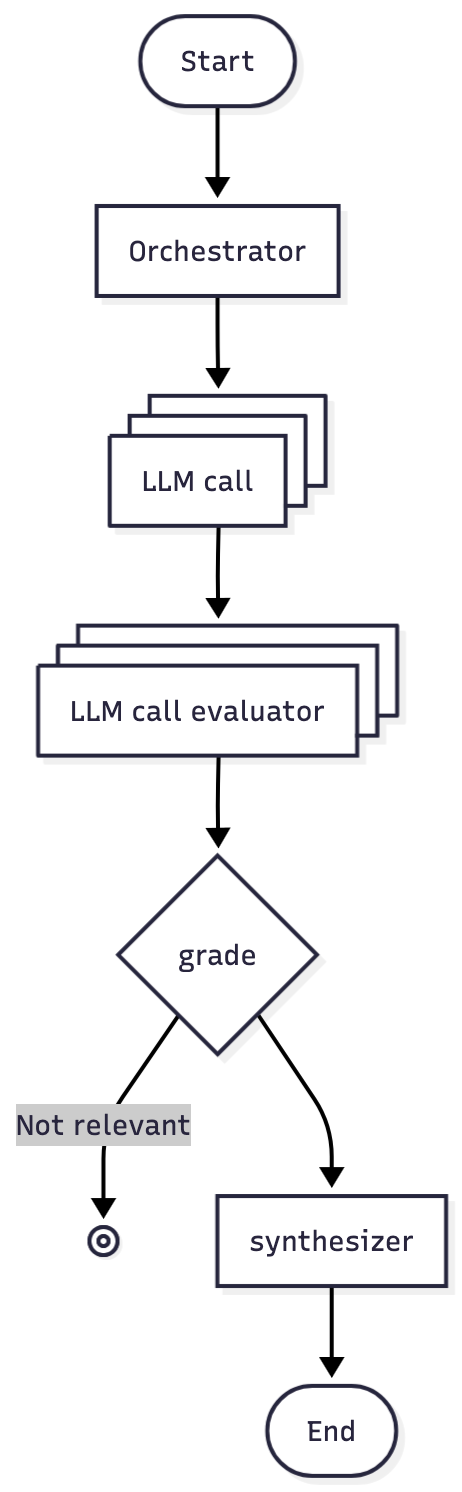

In [5]:
root_path = "/Users/cortizmontesdeoca/Documents/usd/aai-520-group7-final-project/persistence/file_outputs/news_aggregator_chain.png"

from IPython.display import Image
Image(filename=root_path)

In [6]:
state = graph.invoke({"stock_symbol": stock_symbol})

Worker instantiated: Analyzing the Relationship Between AAPL's Earnings Reports, Stock Price Movements, and Investor Sentiment.Worker instantiated: Understanding the Impact of Tim Cook's Leadership on AAPL's Stock Performance and Market Sentiment.
Worker instantiated: Investigating the Effects of Emerging Technologies (e.g., AI, AR, 5G) on AAPL's Product Development and Market Position.

LLM evaluated prompt:Gmail is email that's intuitive, efficient, and useful. 15 GB of storage, less spam, and mobile access.
LLM evaluation result: grade='Not relevant'
LLM evaluated prompt:Emerging technologies are profoundly reshaping societies and industries (Rotolo et al., 2015). Innovations such as artificial intelligence ( AI ), blockchain, the Internet of Things (IoT), mixed reality, and the metaverse are simultaneously refining existing systems and challenging long-standing paradigms. These technologies , though still evolving, are already influencing economic models, social ... The Stanford Em

In [7]:
print(state["macro_financial_report"].content)

Here is a distilled executive summary of the main themes:

**Apple's Leadership and Market Position**

Tim Cook's leadership has had a significant impact on Apple's stock price and market position. Despite being down 7.2% over the past year, Apple remains one of the most iconic and influential companies in the world. The company's brand is shaped by its political involvement under Cook's leadership, which illustrates how social responsibility can align with business goals.

**Emerging Technologies and Their Impact**

Emerging technologies such as artificial intelligence (AI), blockchain, the Internet of Things (IoT), mixed reality, and the metaverse are profoundly reshaping societies and industries. These innovations are refining existing systems and challenging long-standing paradigms, influencing economic models, social structures, and individual behaviors.

**The Role of Digital Technologies in Innovation Ecosystems**

Digital technologies play a crucial role in innovation ecosystem